In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

import os
import numpy as np
# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [2]:
#GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avasilable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Avasilable:  1


2022-06-01 02:00:14.153052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 02:00:14.176140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 02:00:14.176248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Aux function to show a batch


In [3]:
def show_batch(image_batch, label_batch, epoch):
  columns = 5
  rows = BATCH_SIZE / columns + 1  
  epochImages = plt.figure(figsize=(15, 3 * rows))
  epochImages.suptitle('epoch {}'.format(epoch))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batchSimple(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


### Auxiliary functions to load image


In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Function to process images

In [5]:
def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5) - 0.25
    image = tfa.image.rotate(image, r)
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])
    #image = tfa.image.random_hsv_in_yiq(image, 0.5, 0.9, 1.1, 0.9, 1.3)
    #image = tf.image.resize(image, (32,32))
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 
                    0.4,
                    0.4,1.4,
                    0.4, 1.4), 0.0, 1.0)
    return image, label

### Graphs

In [6]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

In [7]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [8]:
#paths para os datasets
pathTrain = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'

BATCH_SIZE = 64
HEIGHT = 32
WIDTH = 32

### Prepare dataset

In [9]:
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)


['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

Total images in dataset:  39220


2022-06-01 02:00:14.544537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 02:00:14.545271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 02:00:14.545460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 02:00:14.545584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:

#train_dataset = dataset
dataset = dataset.shuffle(buffer_size = train_Data_length)
#train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#train_dataset = train_dataset.map(process_image)
# shuffle elements, to shuffle batches place shuffle after batch
#train_dataset = train_dataset.batch(batch_size = BATCH_SIZE)
#train_dataset = train_dataset.repeat()

## Show images for three epochs


IndexError: index 0 is out of bounds for axis 0 with size 0

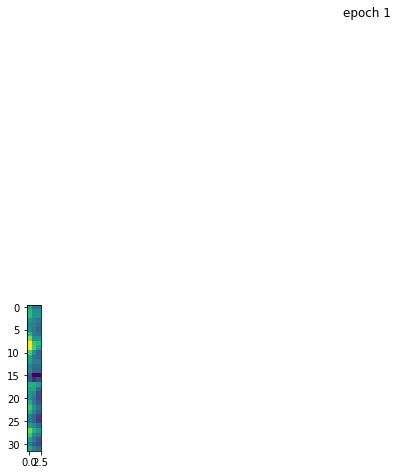

In [12]:

image_batch, label_batch = next(iter(dataset))        
show_batch(image_batch, label_batch.numpy(), 1)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 2)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 3)


### Define simpler functions for data augmentation

In [13]:
def process_image_trans(image, label):
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1), 0.0, 1.0)

    image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=0.1)-0.2),0,1)
    return image, label

## Create a dataset with twice the number of images, one subset is translated, the other is rotated

In [14]:

datasetA = dataset
 
train_dataset = datasetA.map(process_image_trans)
train_dataset = train_dataset.concatenate(datasetA.map(process_image_rot))


/home/falape/.local/lib/python3.10/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.8.1 and trying to load a custom op (custom_ops/image/_distort_image_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.9.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.9.0 and strictly below 2.10.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tensor

In [15]:
train_dataset_length = tf.data.experimental.cardinality(train_dataset).numpy()
print("Total images in dataset: ", train_dataset_length) 

Total images in dataset:  78440


In [16]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_dataset_length)
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
train_dataset = train_dataset.repeat()

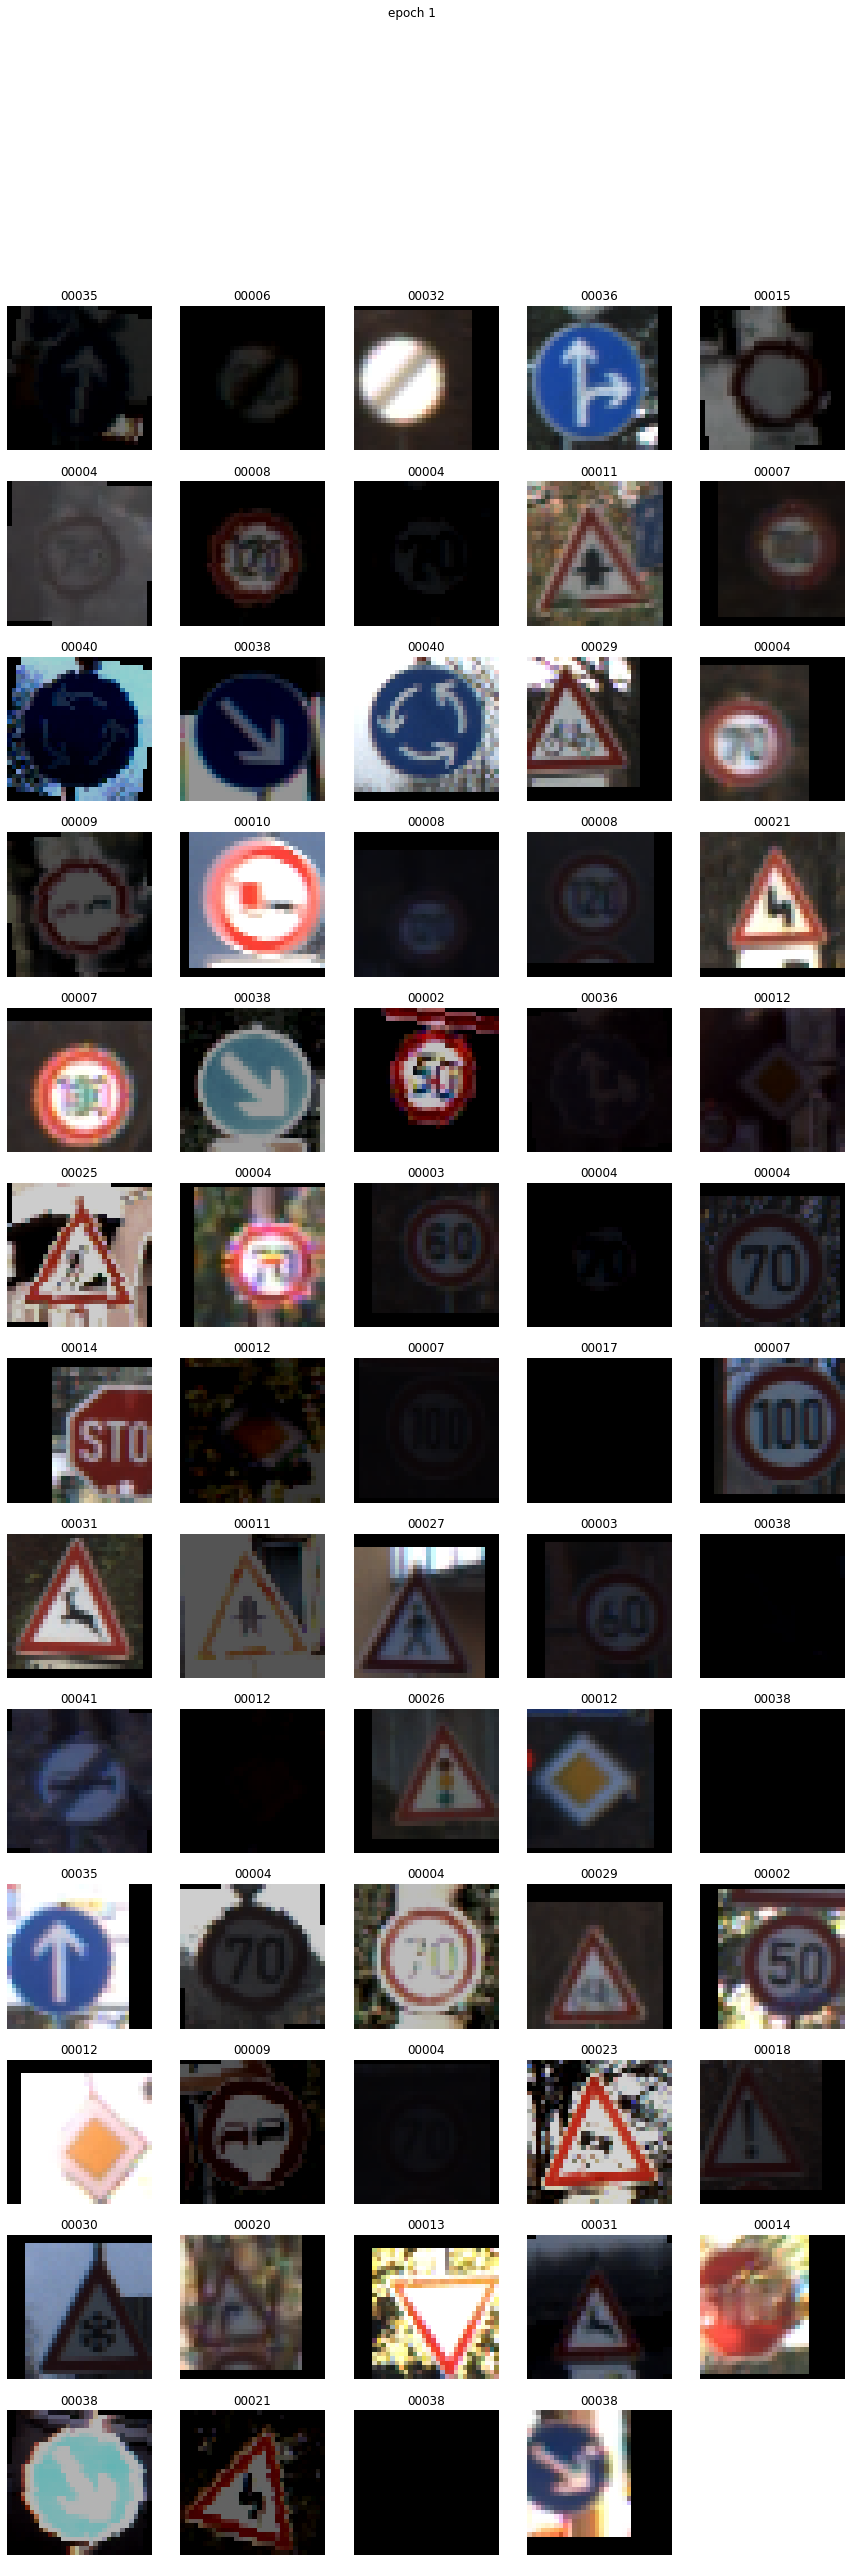

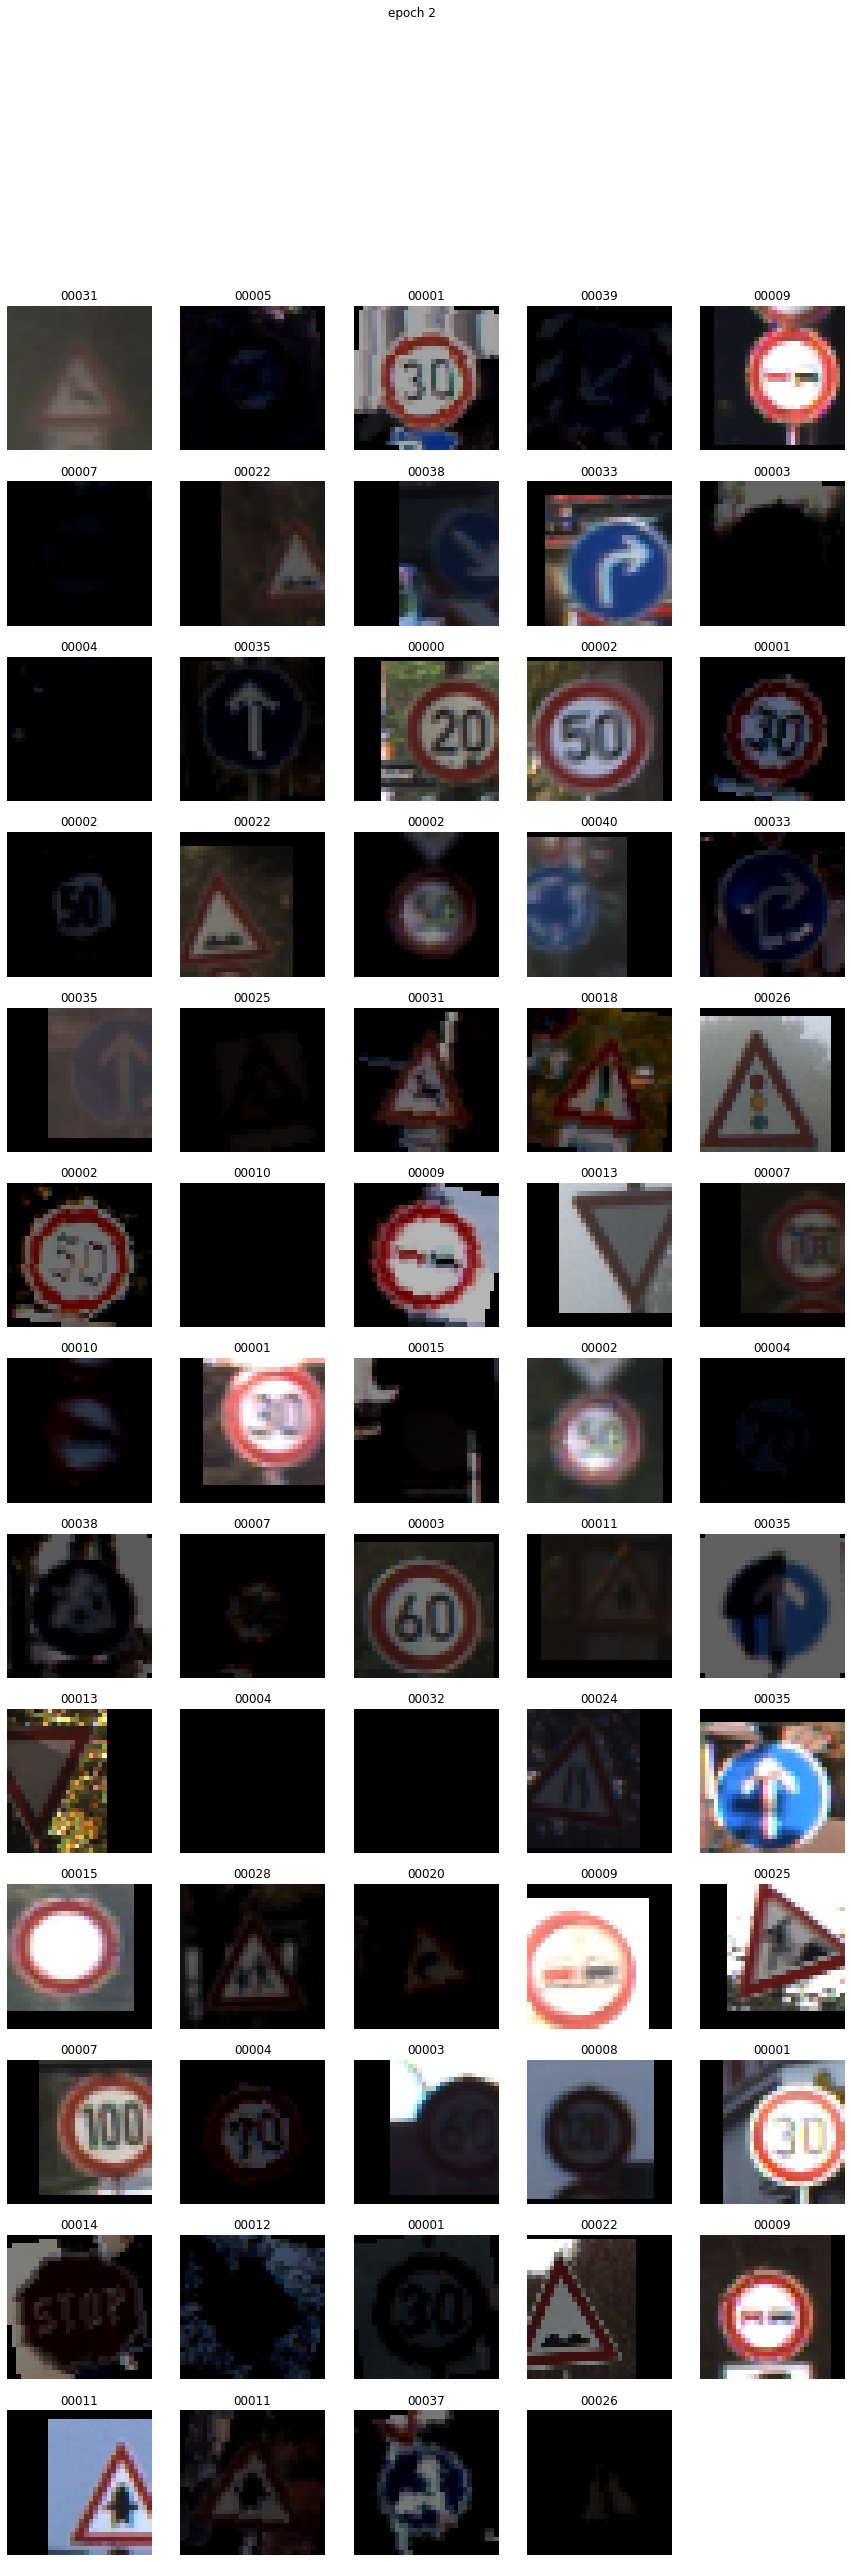

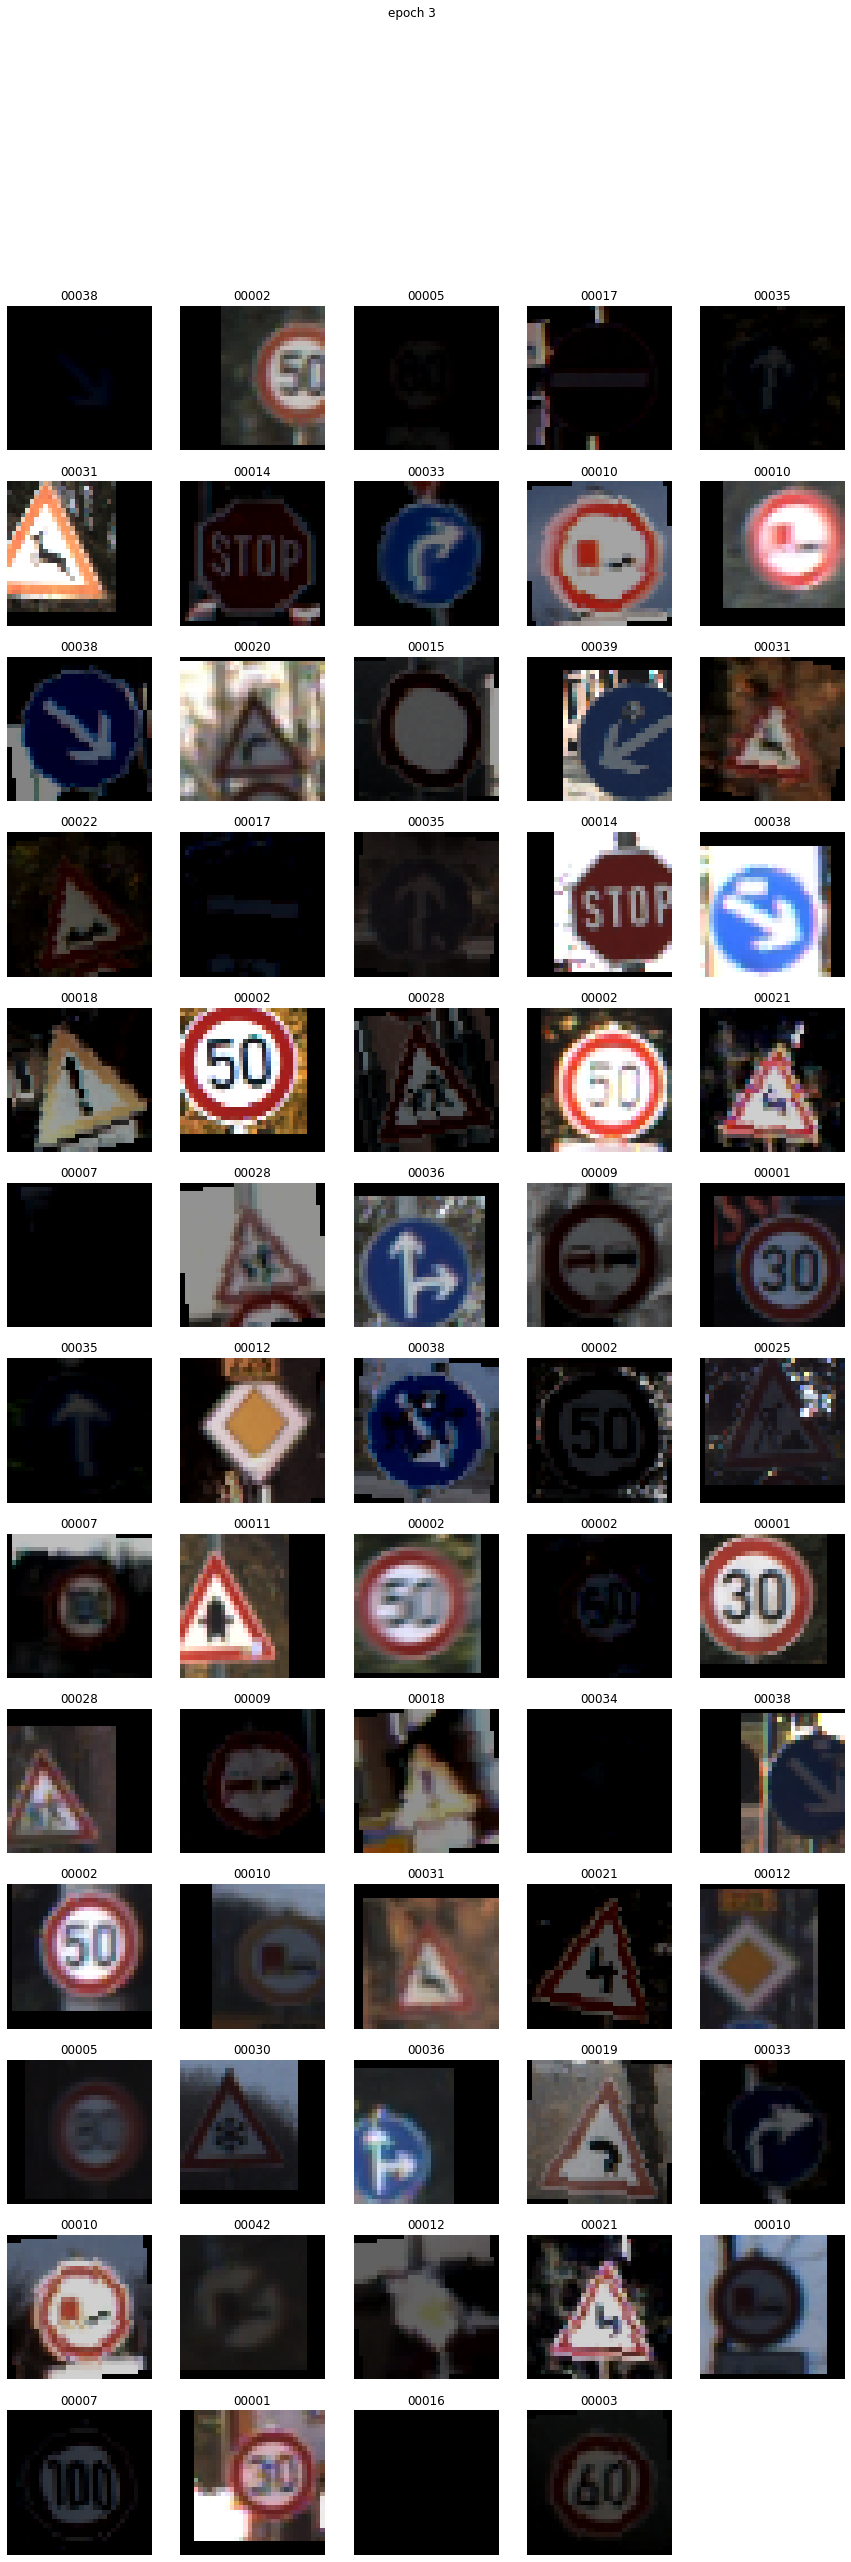

In [17]:
image_batch, label_batch = next(iter(train_dataset))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(train_dataset))      
show_batch(image_batch, label_batch.numpy(), 3)


In [18]:

train_size = int(0.8*train_dataset_length)
val_size = int(0.2*train_dataset_length)

In [19]:
train_Data = train_dataset.take(train_size)
val_Data = train_dataset.skip(train_size)
print(tf.data.experimental.cardinality(train_Data).numpy())

62752


### Test Data Preparation

In [20]:
data_dir = pathlib.Path(pathTest)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


In [21]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [22]:
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)  

Total images in dataset:  12630


In [23]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

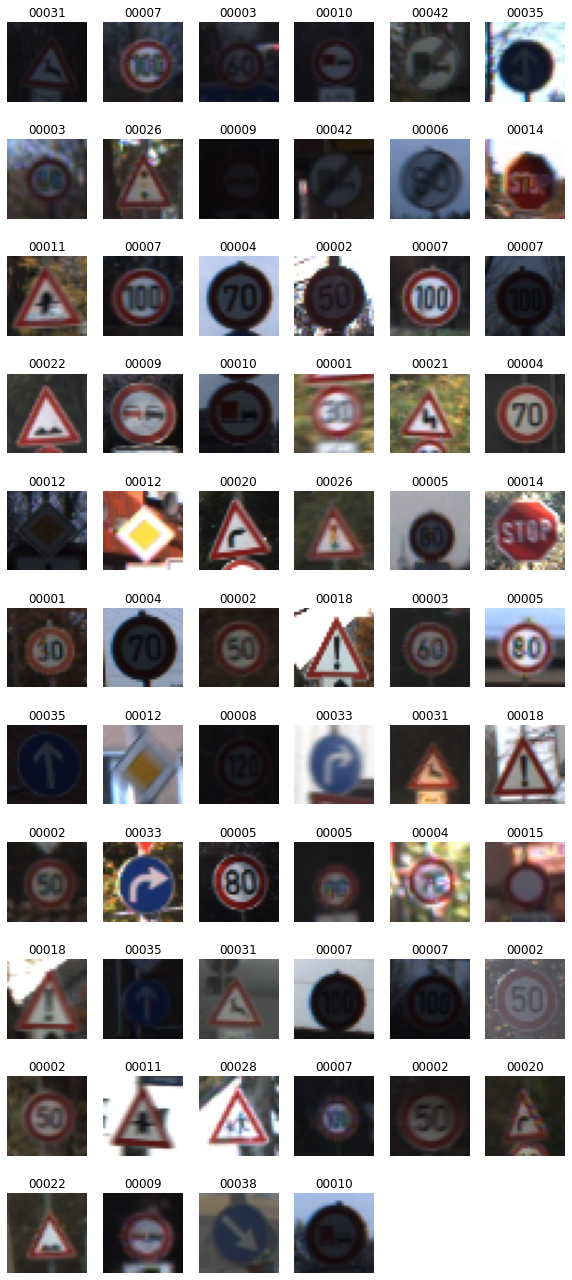

In [24]:
image_batch, label_batch = next(iter(test_Data))        
show_batchSimple(image_batch, label_batch.numpy())

In [25]:
model = Sequential()

model.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
model.add(LeakyReLU(alpha=0.01))  
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(196, (5, 5) )) 
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Conv2D(256, (5, 5) ) )   
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Flatten())
model.add(LeakyReLU(alpha=0.0)) 
model.add(Dense(384))
model.add(LeakyReLU(alpha=0.0))             
model.add(Dropout(0.5)) 

model.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])

In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 196)       0         
                                                        

In [27]:
file_path = './TrainModels/static_Augmentation.ckpt'

callbacks = prepare_callbacks(file_path)

history = model.fit(train_Data, steps_per_epoch = train_size/BATCH_SIZE,
          epochs=30, 
          validation_data=val_Data,
          validation_steps=val_size/BATCH_SIZE, 
          callbacks = callbacks)

Epoch 1/30


2022-06-01 02:00:39.000606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-01 02:00:39.231063: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


981/980 [==============================] - ETA: 0s - loss: 3.1454 - accuracy: 0.1822
Epoch 1: val_accuracy improved from -inf to 0.40263, saving model to ./TrainModels/static_Augmentation.ckpt
980/980 [==============================] - 46s 45ms/step - loss: 3.1454 - accuracy: 0.1822 - val_loss: 2.1081 - val_accuracy: 0.4026 - lr: 1.0000e-04
Epoch 2/30
980/980 [============================>.] - ETA: 0s - loss: 2.0091 - accuracy: 0.4283
Epoch 2: val_accuracy improved from 0.40263 to 0.64336, saving model to ./TrainModels/static_Augmentation.ckpt
980/980 [==============================] - 45s 46ms/step - loss: 2.0088 - accuracy: 0.4284 - val_loss: 1.2215 - val_accuracy: 0.6434 - lr: 1.0000e-04
Epoch 3/30
981/980 [==============================] - ETA: 0s - loss: 1.3984 - accuracy: 0.5847
Epoch 3: val_accuracy improved from 0.64336 to 0.76683, saving model to ./TrainModels/static_Augmentation.ckpt
980/980 [==============================] - 45s 46ms/step - loss: 1.3984 - accuracy: 0.5847 - 

### Load Modelo treinado

In [28]:
#model.load_weights(file_path)

#evalV1 = model.evaluate(test_Data, verbose=2)
#valV1 = model.evaluate(val_Data, steps=1, batch_size=0.2 * train_Data_length, verbose=2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


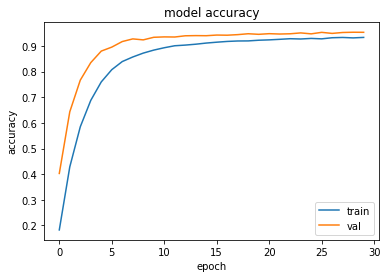

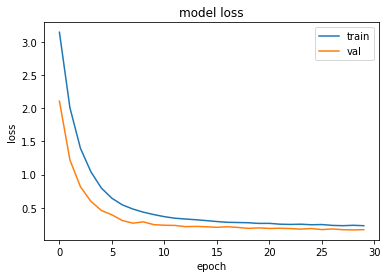

In [29]:
show_history(history)

In [30]:
model_eval = model.evaluate(test_Data, verbose=2)
print(model_eval)

model_val = model.evaluate(val_Data, steps=1, batch_size=val_size, verbose=2)
print(model_val)

198/198 - 3s - loss: 0.0467 - accuracy: 0.9854 - 3s/epoch - 13ms/step
[0.04674302786588669, 0.9854314923286438]
1/1 - 9s - loss: 0.2274 - accuracy: 0.9219 - 9s/epoch - 9s/step
[0.22742868959903717, 0.921875]


In [31]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in test_Data.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(model.predict(images.numpy()))


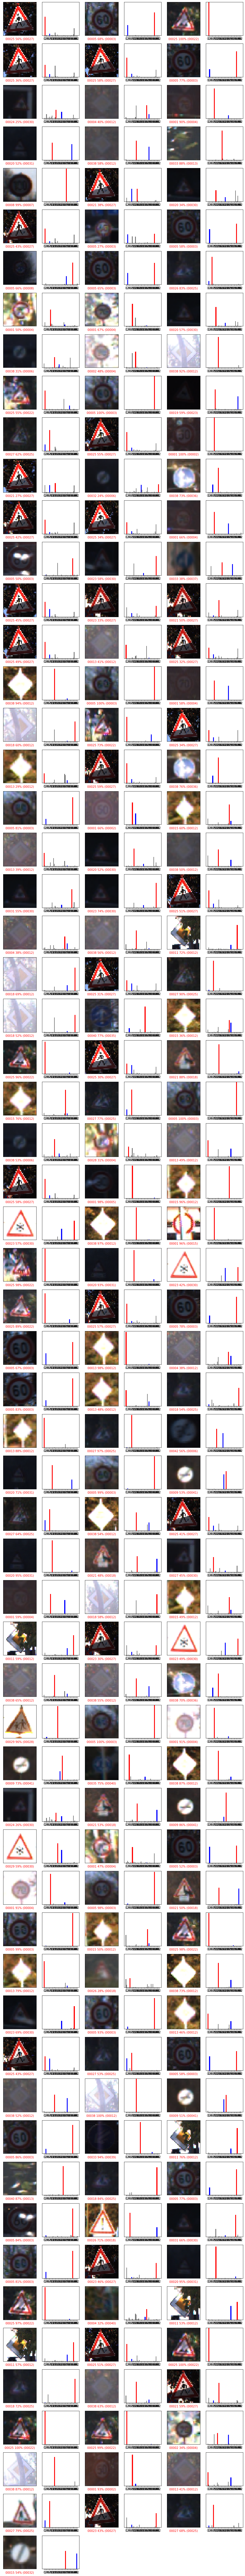

In [33]:
show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9861 )/3 + 1))